In [1]:
import numpy as np
import matplotlib as mp
import matplotlib.pyplot as plt
import HbXConcentrations as hbx
import json
import auxFuncs as aux
from scipy.ndimage import median_filter

In [2]:
# Load sample Phantom experiments

# Attenuation maps
reconPhantom1 = np.loadtxt("Phantom_660nm_Mean.dat")
reconPhantom2 = np.loadtxt("Phantom_830nm_Mean.dat")

shapeReconPhantom1 = np.shape(reconPhantom1)
shapeReconPhantom2 = np.shape(reconPhantom2)

# Reconstruction data
with open("Phantom_660nm_reconData.json") as json_file:
    reconData = json.load(json_file)

# Center positions and shape
centersShape = reconData['centersShape']
centersPos = np.fromfile("Phantom_660nm_centers.bin", dtype=np.int16).reshape(centersShape)

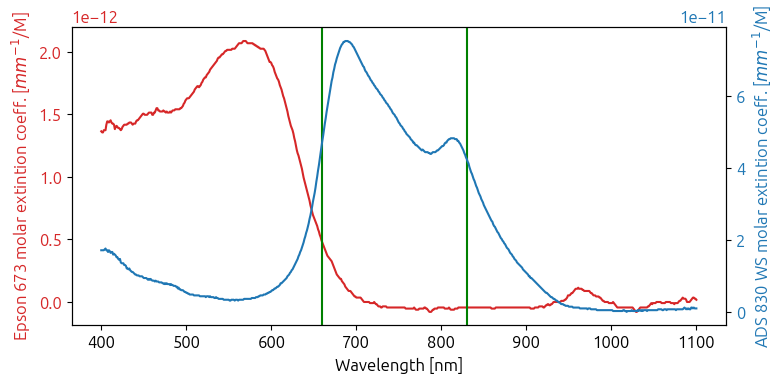

In [3]:
lambdas = [660, 830]

spectraData1 = "epson673.dat"
spectraData2 = "ads830WS.dat"

concADS = 4.13745e9 #g/ml
concEpson = 2.2715e10 #g/ml

spectraArray1 = np.loadtxt(spectraData1)
spectraArray2 = np.loadtxt(spectraData2)



font = {'family': 'ubuntu',
        'weight': 'regular',
        'size': 12}

plt.rc('font', **font)

fig, ax1 = plt.subplots(figsize=(8, 4))

color = 'tab:red'
ax1.set_xlabel('time (s)')
ax1.set_ylabel('Epson 673 molar extintion coeff. [$mm^{-1}$/M]', color=color)
ax1.plot(spectraArray1[:, 0], aux.movingAverage(spectraArray1[:, 1],5) / concEpson, color=color, label="Epson 673")
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('Relative absorption', color=color)  # we already handled the x-label with ax1
ax2.plot(spectraArray2[:, 0], spectraArray2[:, 1] / concADS, color=color, label="ADS 830 WS")
ax2.tick_params(axis='y', labelcolor=color)

ax1.set_xlabel("Wavelength [nm]")
ax2.set_ylabel("ADS 830 WS molar extintion coeff. [$mm^{-1}$/M]")

fig.tight_layout()  # otherwise the right y-label is slightly clipped



for l in lambdas:
    ax1.axvline(x=l, color='green')


plt.savefig("inksSpectra.png", bbox_inches='tight', dpi=300)


In [4]:
imRaw = np.zeros((np.shape(reconPhantom1)[0], np.shape(reconPhantom1)[1], 2))
imRaw[:,:,0] = reconPhantom1
imRaw[:,:,1] = reconPhantom2

cropSize = 250

HbXMaps_2D = hbx.MamoRef_dHbX(imRaw, lambdas, centersPos, cropSize, cropSize, spectraData1 = spectraData1, spectraData2 = spectraData2, 
                              concentration1=concEpson, concentration2=concADS, ua=0.002)
    
desOxyMap_Phantom_2D = HbXMaps_2D[:,:,1]
OxyMap_Phantom_2D = HbXMaps_2D[:,:,0]
TotMap_Phantom_2D = desOxyMap_Phantom_2D + OxyMap_Phantom_2D

Step 1/2...


100%|██████████| 250/250 [00:37<00:00,  6.64it/s]


Step 2/2...


100%|██████████| 70/70 [05:05<00:00,  4.37s/it]
/home/nicolas/Bionirs/MamoRefCodePublic/HbXConcentrations.py:162: RuntimeWarning: invalid value encountered in divide
  LL = LL/cont


In [5]:
# Flip to match real positions

desOxyMap_Phantom_2D = np.flip(desOxyMap_Phantom_2D, axis=1)
OxyMap_Phantom_2D = np.flip(OxyMap_Phantom_2D, axis=1)
TotMap_Phantom_2D = np.flip(TotMap_Phantom_2D, axis=1)


#desOxyMap_Phantom_2D_filtered = ndimage.median_filter(desOxyMap_Phantom_2D,10)
#OxyMap_Phantom_2D_filtered = ndimage.median_filter(OxyMap_Phantom_2D,10)

desOxyMap_Phantom_2D_filtered = aux.fftGauss(desOxyMap_Phantom_2D,5)[0]
OxyMap_Phantom_2D_filtered = aux.fftGauss(OxyMap_Phantom_2D,5)[0]

#desOxyMap_Phantom_2D_filtered = desOxyMap_Phantom_2D
#OxyMap_Phantom_2D_filtered = OxyMap_Phantom_2D

desOxyMap_Phantom_2D_filtered[desOxyMap_Phantom_2D_filtered==np.nan] = 1
OxyMap_Phantom_2D_filtered[OxyMap_Phantom_2D_filtered==np.nan] = 1

/home/nicolas/Bionirs/MamoRefCodePublic/auxFuncs.py:103: ComplexWarning: Casting complex values to real discards the imaginary part
  im_output[~in_NaNs] = im_filtered[~in_NaNs]


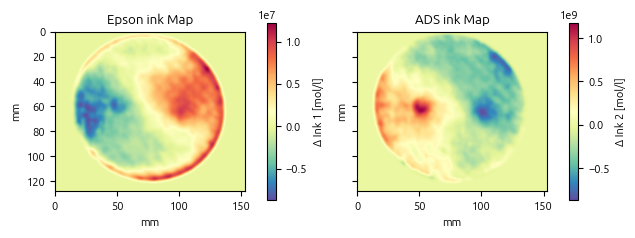

In [6]:
colorMap = "Spectral_r"
    
font = {'family' : 'ubuntu',
        'weight' : 'regular',
        'size'   : 8}

mp.rc('font', **font)

doTotMap = False

scale = 4
extent = [0, int(np.shape(desOxyMap_Phantom_2D_filtered)[1]/scale), int(np.shape(desOxyMap_Phantom_2D_filtered)[0]/scale), 0]


if doTotMap:
        figSats, ((DesOxy, Oxy, Tot)) = plt.subplots(1, 3, sharex=True, sharey=True)
        font["size"] = 6
else:
        figSats, ((DesOxy, Oxy)) = plt.subplots(1, 2, sharex=True, sharey=True)        

maxDev = 3   

sd = np.nanstd(desOxyMap_Phantom_2D_filtered)
median = np.nanmedian(desOxyMap_Phantom_2D_filtered)
vmax = median + maxDev * sd
vmin = median - maxDev * sd

figDesOxy = DesOxy.imshow(desOxyMap_Phantom_2D_filtered, cmap=mp.colormaps[colorMap], extent=extent)
DesOxy.set_xlabel("mm")
DesOxy.set_ylabel("mm")

c1 = figSats.colorbar(figDesOxy, ax=DesOxy, fraction=0.04, pad=0.1)
c1.set_label("Δ Ink 1 [mol/l]")


sd = np.nanstd(OxyMap_Phantom_2D_filtered)
median = np.nanmedian(OxyMap_Phantom_2D_filtered)
vmax = median + maxDev * sd
vmin = median - maxDev * sd


figOxy = Oxy.imshow(OxyMap_Phantom_2D_filtered, cmap=mp.colormaps[colorMap], extent=extent)
c2 = figSats.colorbar(figOxy, ax=Oxy, fraction=0.04, pad=0.1)
c2.set_label("Δ Ink 2 [mol/l]")
Oxy.set_xlabel("mm")
Oxy.set_ylabel("mm")

if doTotMap:
        TotMap_Phantom_2D = desOxyMap_Phantom_2D_filtered + OxyMap_Phantom_2D_filtered

        sd = np.nanstd(TotMap_Phantom_2D)
        median = np.nanmedian(TotMap_Phantom_2D)
        vmax = median + maxDev * sd
        vmin = median - maxDev * sd


        figTot = Tot.imshow(TotMap_Phantom_2D, vmin=vmin, vmax=vmax, cmap=mp.colormaps[colorMap], extent=extent)
        c3 = figSats.colorbar(figTot, ax=Tot, fraction=0.04, pad=0.1)
        c3.set_label("Δ HbTot [mol/l]")
        Tot.set_xlabel("mm")
        Tot.set_ylabel("mm")

DesOxy.set_title("Epson ink Map")

Oxy.set_title("ADS ink Map")

if doTotMap:
        Tot.set_title("Total HB HBMap")


figSats.tight_layout()

figSats.savefig("PhantomIncs_inkMaps.png", bbox_inches='tight', dpi=300)